<h1>AUTHOR - HARSHWARDHAN NATU</h1>


<h2>Stock Market Prediction using Numerical and Textual Analysis</h2>

<h3>Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)</h3>

<h1>Import the Important Libraries</h1>

In [1]:
!pip install textblob
!pip install xgboost
!pip install lightgbm
!pip install pandas_datareader
!pip install pmdarima

In [2]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [3]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [4]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv",names=columns)

In [5]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [6]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3424058,20201231,50 NRIs reach Singhu; offer help to farmers
3424059,20201231,Navjot Singh Sidhu tweets apology; says 'wore ...
3424060,20201231,Azim Premji organisation's name misused to che...
3424061,20201231,Get govt nod to probe officials: MP to agencies


In [7]:
# Load the second dataset
hisdf = pd.read_csv("^BSESN.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,46103.500000,20700.0


<h1>Common Dataset Exploration</h1>

In [8]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


In [9]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [10]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [11]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [12]:
len(ndf)

7262

In [13]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0
...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,20700.0


In [14]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [15]:
hisdf.describe()

,Open,High,Low,Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
std,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333
min,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000


In [16]:
# Check for duplicated values
hisdf.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    2
dtype: int64

In [17]:
len(hisdf)

252

Text(0, 0.5, 'BSESN')

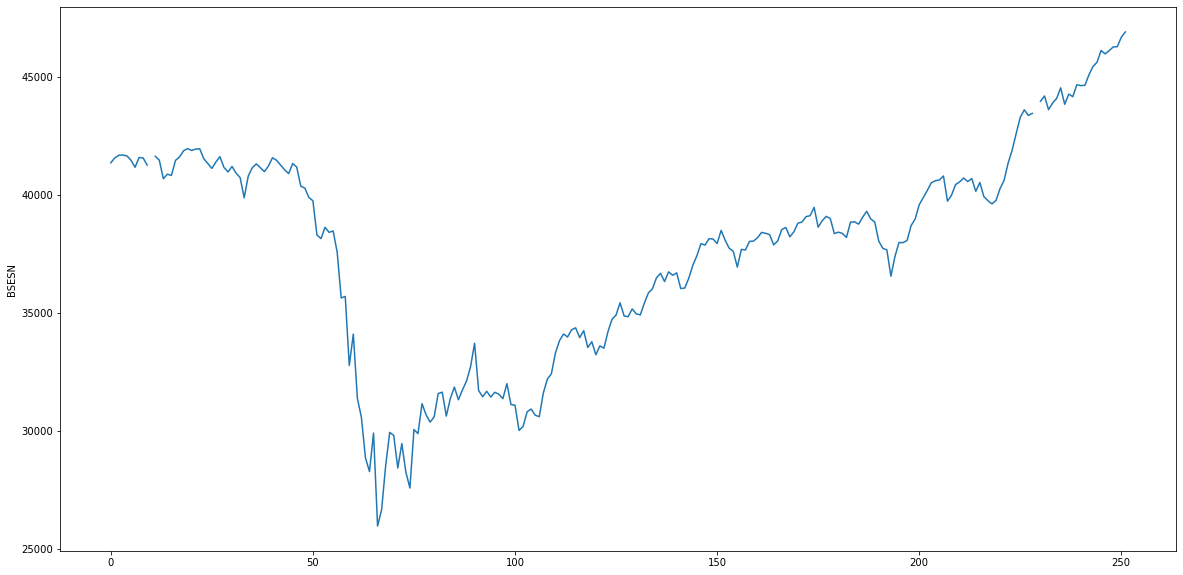

In [18]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

<h1>Remove Unwanted Characters from the News</h1?

In [19]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

<h1>Historical Analysis
Plot the Moving Average</h1>

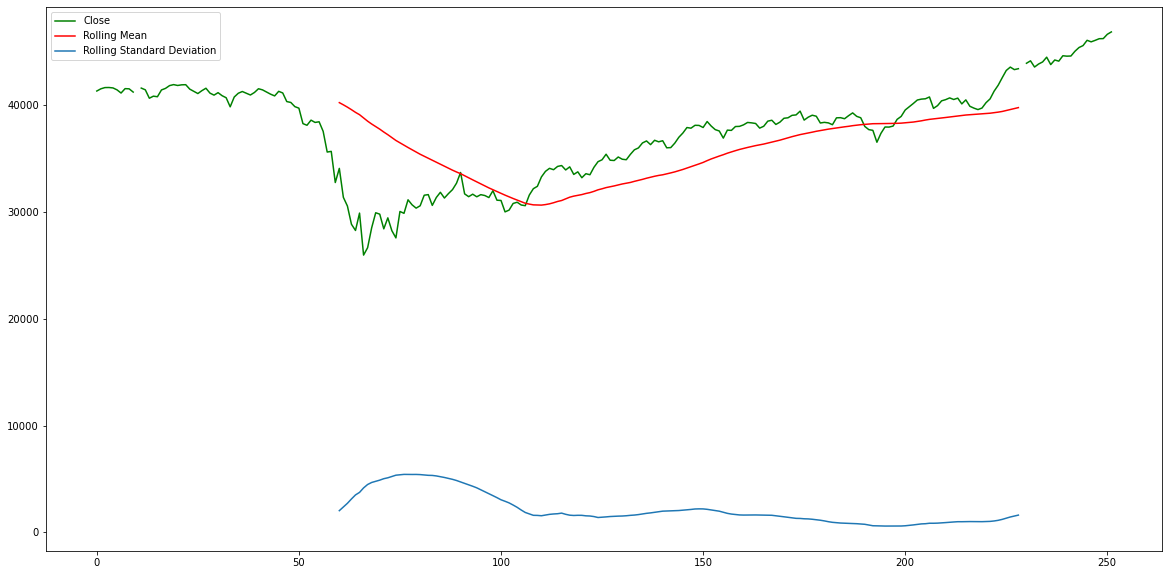

In [20]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

<h1>Plot the Returns</h1>

Text(0.5, 1.0, 'Returns')

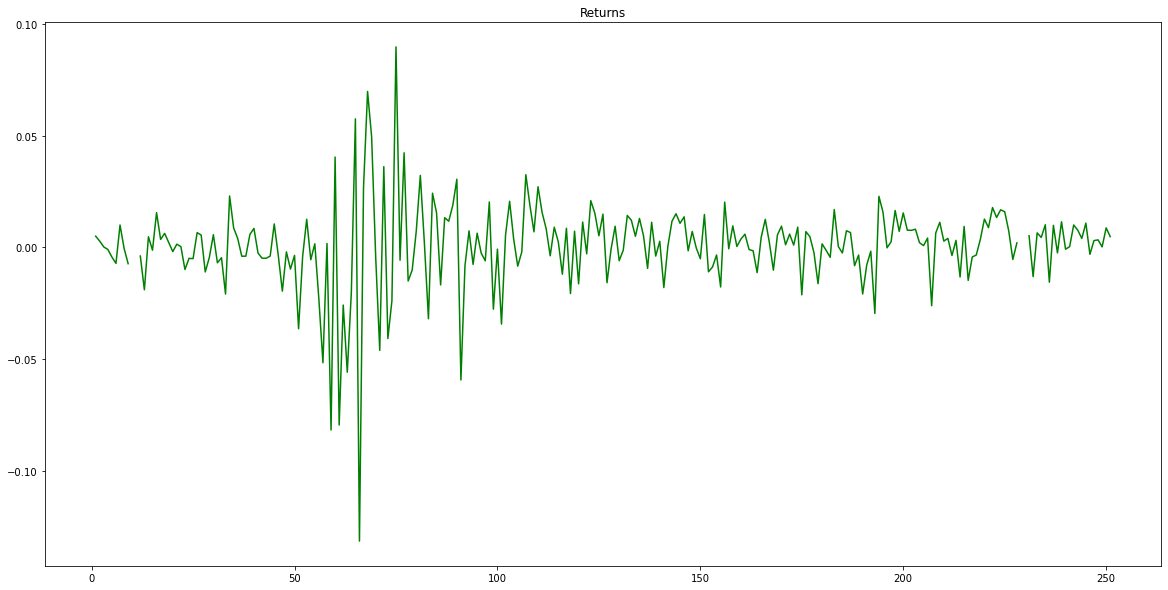

In [21]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [22]:

# Train test split
train = hisdf[:1219]
test = hisdf[1219:]

<h1>Rolling mean and Standard Deviation</h1>

In [23]:
#Stationarity test
def test_stationarity(timeseries):

#Determine the rolling statistics
rolmean = timeseries.rolling(20).mean()
rolstd = timeseries.rolling(20).std()

#Plot rolling statistics:
plt.figure(figsize = (20,10))
plt.plot(timeseries, color = 'blue', label = 'original')
plt.plot(rolmean, color = 'r', label = 'rolling mean')
plt.plot(rolstd, color = 'black', label = 'rolling std')
plt.xlabel('Date')
plt.legend()
plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
plt.show(block = False)
 
print('Results of dickey fuller test')
result = adfuller(timeseries, autolag = 'AIC')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
for value,label in zip(result, labels):
    print(label+' : '+str(value) )
if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

IndentationError: expected an indented block (<ipython-input-23-741f2ae1d7d8>, line 5)

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

In [ ]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

<h1>Error Calculation

In [ ]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

<h1>Textual Analysis

In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

In [ ]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [ ]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

<h1>Merge the Historical and Textual Data

In [ ]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')
df_merge

<h1>Create Dataset for Model Training

In [ ]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

<h1>Normalize Data

In [ ]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

In [ ]:
X=df.drop('Close',axis=1)
X

In [ ]:
Y=df['Close']
Y

<h1>Split the Dataset into Train & Test Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

In [ ]:
x_train[:10]

<h1>RandomForestRegressor Model

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [ ]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

<h1>DecisionTreeRegressor Model

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [ ]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

<h1>AdaBoostRegressor Model

In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

In [ ]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

<h1>LGBMRegressor Model

In [ ]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

In [ ]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

<h1>XGBRegressor Model

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

In [ ]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

<h1>Conclusion¶

<h3>RandomForest = 0.05257968397499098

<h3>DecisionTree = 0.10831900809236311

<h3>AdaBoost = 0.05492347045438241

<h3>LightGBM = 0.0583079056070462

<h3>XGBoost = 0.05968830860645931 From here we can see that RandomForestRegressor shows a better performance than the others

<h4>THANK YOU !